# Skip-gram with negative sampling

In [58]:
# import statements
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import re
import random
from tqdm import tqdm
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

## Data preprocessing

In [2]:
# function to tokenize and preprocess the data
def tokenize_and_preprocess(text):
    # Remove digits, possessive apostrophes, and special characters
    text = re.sub(r'\d', '', text)
    # Remove "'s" from any word it occurs
    text = re.sub(r"'s\b", '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r"[’']", '', text)

    # Remove hyphens and extra spaces
    words = re.findall(r'\b\w+\b', text.lower())

    # Define some stop words
    stop_words = set(["the", "and", "is", "of", "a", "an", "in", "to", "for"])

    # Remove stop words from the list of words
    words = [word for word in words if word not in stop_words]

    return words

# function to load the data
def load_and_tokenize_data(csv_file):
    # Load the CSV file into a pandas dataframe
    df = pd.read_csv(csv_file, header=0)

    # Extract the labels 
    labels = df['Class Index'].tolist()

    # Tokenize the sentences and store them as  list of lists 
    descriptions = [tokenize_and_preprocess(desc) for desc in df['Description'].tolist()]

    return labels, descriptions

# function to map unique tokens to unique ids
def build_vocab_mapping(token_lists):
    # flatten the list of lists to get all tokens from all sentences
    all_tokens = [token for tokens in token_lists for token in tokens]

    # Get unique tokens
    unique_tokens = list(set(all_tokens))

    # Create the mapping of tokens to unique IDs
    token_to_id = {token: idx for idx, token in enumerate(unique_tokens)}

    return token_to_id

# function to generate the unigram frequencies
def generate_unigram_frequencies(token_to_id, token_lists):
    word_frequencies = {token_id: 0 for token_id in token_to_id.values()}

    for token_list in token_lists:
        for token in token_list:
            token_id = token_to_id.get(token, None)
            if token_id is not None:
                word_frequencies[token_id] += 1
    print('done')
    return word_frequencies

# function to generate target-context pairs
def generate_context_pairs(token_lists, token_to_id, context_window):
    context_pairs = []

    for tokens in token_lists:
        for i in range(len(tokens)):
            target = tokens[i]
            target_id = token_to_id[target]

            start_idx = max(0, i - context_window)
            end_idx = min(len(tokens), i + context_window + 1)
            context = tokens[start_idx:i] + tokens[i+1:end_idx]

            for context_word in context:
                context_id = token_to_id[context_word]
                context_pairs.append((target_id, context_id, 1))
    print('done')
    return context_pairs

# function to generate target-negative pairs
def negative_sampling(target_context_pairs, word_frequencies, num_negative_samples=4):
    negative_pairs = []
    vocabulary_size = len(word_frequencies)

    # Create a mapping of target words to their associated context words
    target_to_context_mapping = {}
    for target_id, context_id, _ in target_context_pairs:
        if target_id not in target_to_context_mapping:
            target_to_context_mapping[target_id] = []
        target_to_context_mapping[target_id].append(context_id)

    # Generate negative samples for each target word
    for target_id, context_words in target_to_context_mapping.items():
        negative_sample_ids = []
        while len(negative_sample_ids) < num_negative_samples:
            # Sample a negative ID from the vocabulary
            negative_id = random.randint(0, vocabulary_size - 1)

            # Check if the negative ID is not the target word and not a context word for the target
            if negative_id != target_id and negative_id not in context_words:
                negative_sample_ids.append(negative_id)

        # Append the target ID and the negative sample IDs to the negative pairs
        for negative_id in negative_sample_ids:
            negative_pairs.append((target_id, negative_id, 0))
    print('done')
    return negative_pairs

# Replace 'your_csv_file.csv' with the actual file path of your AG News dataset CSV file
csv_file_path = 'train.csv'
train_labels, train_descriptions = load_and_tokenize_data(csv_file_path)
token_to_id_train = build_vocab_mapping(train_descriptions)
vocab_len = len(token_to_id_train)
# generate target-context pairs
target_context_pairs = generate_context_pairs(train_descriptions, token_to_id_train, context_window=2)
# obtain the unigram frequencies
unigram_frequencies = generate_unigram_frequencies(token_to_id_train, train_descriptions)
# sample negative pairs
target_negative_pairs = negative_sampling(target_context_pairs, unigram_frequencies)

# randomly shuffle the target-context pairs, combine some with negative pairs for training
random.shuffle(target_context_pairs)
training_data = target_context_pairs[:300000] + target_negative_pairs
# Save the training_data list to a file using pickle
with open('training_data.pkl', 'wb') as f:
    pickle.dump(training_data, f)  
# Load the training_data list from the file
with open('training_data.pkl', 'rb') as f:
    training_data = pickle.load(f)

## Model building and Training

## Model Training

In [4]:
# Skipgram with Negative Sampling
class SkipGramWithNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramWithNegativeSampling, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, target_id, context_id):
        # Embedding lookup for target and context/negative word IDs
        target_embed = self.embeddings(target_id)
        context_embed = self.embeddings(context_id)

        # Compute the dot product of target and context/negative embeddings
        dot_product = torch.sum(target_embed * context_embed, dim=1)

        # Apply sigmoid to estimate probability
        output = self.sigmoid(dot_product)
        return output

In [6]:
# define the hyperparameters
vocab_size = vocab_len 
embedding_dim = 300  
num_epochs = 30
batch_size = 512
learning_rate = 0.001  

# define the model
model = SkipGramWithNegativeSampling(vocab_size, embedding_dim)
# Define the loss function (binary cross-entropy) and the Adam optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Shuffle the data before training
random.shuffle(training_data)

# Create a list to store the training loss 
loss_list = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    total_loss = 0.0
    # Set the model to training mode
    model.train()

    # Create progress bar using tqdm 
    data_iterator = tqdm(range(0, len(training_data), batch_size), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    # Loop over the batches of data
    for batch_start in data_iterator:
        batch_data = training_data[batch_start: batch_start + batch_size]
        target_ids, context_ids, labels = zip(*batch_data)

        target_ids = torch.tensor(target_ids, dtype=torch.long).to(device)
        context_ids = torch.tensor(context_ids, dtype=torch.long).to(device)
        labels = torch.tensor(labels, dtype=torch.float).to(device)  # Use float for binary cross-entropy

        # Zero the gradients to avoid accumulation
        optimizer.zero_grad()

        # Forward pass through the model 
        probabilities = model(target_ids, context_ids)

        # Calculate the binary cross-entropy loss
        loss = criterion(probabilities, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print the average loss for the epoch and the total loss
    avg_loss = total_loss / (len(training_data) // batch_size)
    loss_list.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {avg_loss:.4f}")

    # Save the model after each epoch
    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pt")

print("Training completed.")

Epoch 1/30, Total Loss: 12347.3709


Epoch 2/30, Total Loss: 10423.4868


Epoch 3/30, Total Loss: 9237.6064


Epoch 4/30, Total Loss: 8592.2709


Epoch 5/30, Total Loss: 8167.6865


Epoch 6/30, Total Loss: 7877.0494


Epoch 7/30, Total Loss: 7677.8099


Epoch 8/30, Total Loss: 7543.1742


Epoch 9/30, Total Loss: 7448.2230


Epoch 10/30, Total Loss: 7374.0885


Epoch 11/30, Total Loss: 7316.5096


Epoch 12/30, Total Loss: 7265.6283


Epoch 13/30, Total Loss: 7225.5269


Epoch 14/30, Total Loss: 7190.4226


Epoch 15/30, Total Loss: 7159.0929


Epoch 16/30, Total Loss: 7130.9453


Epoch 17/30, Total Loss: 7103.1087


Epoch 18/30, Total Loss: 7077.7662


Epoch 19/30, Total Loss: 7054.6990


Epoch 20/30, Total Loss: 7035.9416


Epoch 21/30, Total Loss: 7019.0652


Epoch 22/30, Total Loss: 7000.8444


Epoch 23/30, Total Loss: 6983.6561


Epoch 24/30, Total Loss: 6970.2225


Epoch 25/30, Total Loss: 6959.5316


Epoch 26/30, Total Loss: 6948.5515


Epoch 27/30, Total Loss: 6937.2850


Epoch 28/30, Total Loss: 6928.8277


Epoch 29/30, Total Loss: 6921.1944


Epoch 30/30, Total Loss: 6913.3432
Training completed.


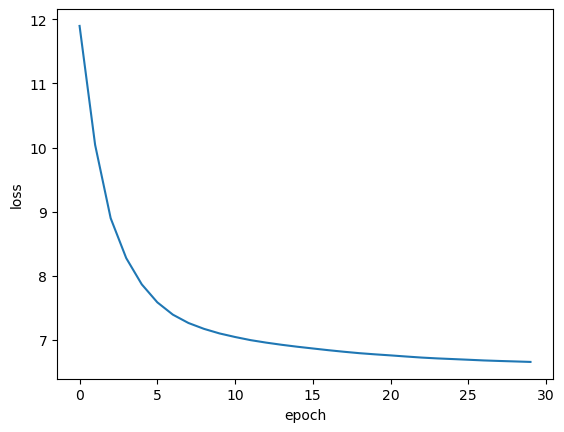

In [27]:
# plot the loss function during the training
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Visualize the trained Word Embeddings

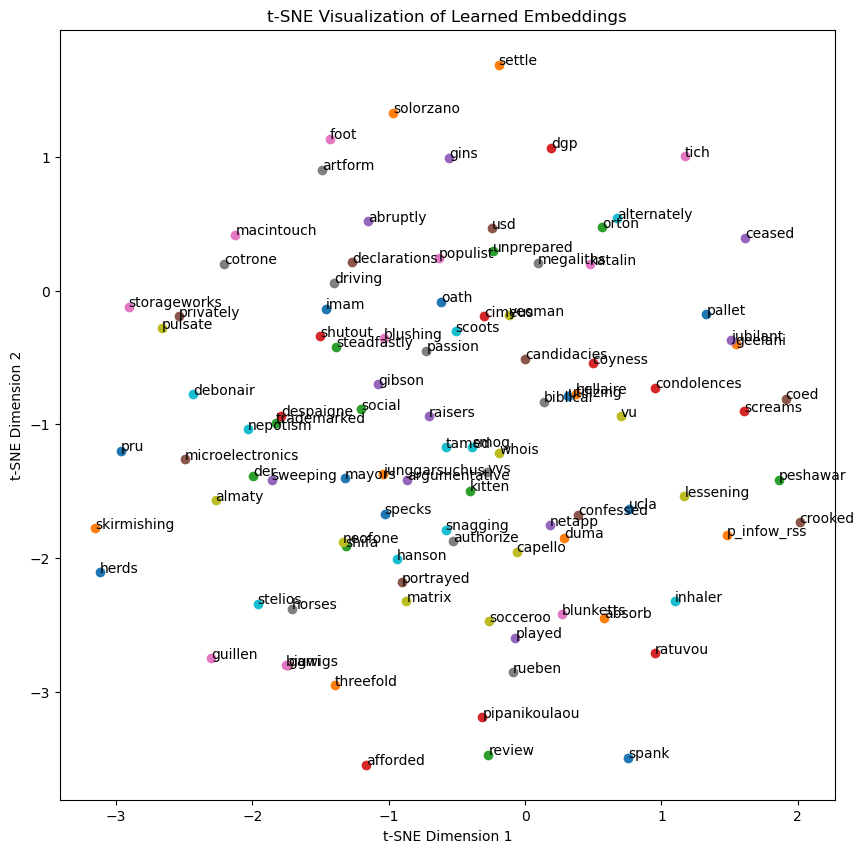

In [65]:
# Load the model from the saved state dict
loaded_model = SkipGramWithNegativeSampling(vocab_size, embedding_dim)
loaded_model.load_state_dict(torch.load("model_epoch_30.pt"))

# Extract the learned embeddings from the model
embeddings = loaded_model.embeddings.weight.data.cpu().numpy()

# Select a subset of embeddings for visualization 
num_embeddings_to_visualize = 100
selected_embeddings = embeddings[:num_embeddings_to_visualize, :]

# Get the corresponding word tokens for the selected embeddings
selected_word_tokens = list(token_to_id_train.keys())[:num_embeddings_to_visualize]

# Use t-SNE to reduce the dimensionality of the embeddings to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
embedded_embeddings = tsne.fit_transform(selected_embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 10))
for i, word_token in enumerate(selected_word_tokens):
    x, y = embedded_embeddings[i, :]
    plt.scatter(x, y)
    plt.text(x, y, word_token, fontsize=10)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Learned Embeddings')
plt.show()



## Cosine Distances

In [50]:
def cosine_distances(embeddings, word_tokens, token_to_id_train, query_word):
    num_words = len(word_tokens)
    distances_table = np.zeros(num_words)

    query_embedding = embeddings[token_to_id_train[query_word]]

    for i in range(num_words):
        word_token_i = word_tokens[i]
        embedding_i = embeddings[token_to_id_train[word_token_i]]
        distances_table[i] = cosine(query_embedding, embedding_i)

    # Get the indices of the 5 closest words 
    closest_indices = np.argsort(distances_table)[1:6]
    closest_words = [word_tokens[idx] for idx in closest_indices]
    closest_similarities = [distances_table[idx] for idx in closest_indices]

    # Combine the closest words with their cosine similarities
    closest_results = [(word, similarity) for word, similarity in zip(closest_words, closest_similarities)]
    print('Closest words to ' + query_word + ':')
    for word, similarity in closest_results:
        print(f"{word} ({similarity:.4f})")
    

    return closest_results

# evaluate the cosine distances
query_words = ['wild', 'market', 'space', 'paris']
word_tokens = list(token_to_id_train.keys())
for i in range(len(query_words)):
    cosine_distances(embeddings, word_tokens, token_to_id_train, query_words[i])

Closest words to wild:
ramat (0.7649)
chatlos (0.7670)
brilliance (0.7677)
servgate (0.7766)
intensively (0.7788)
Closest words to market:
depository (0.7734)
switzerland (0.7890)
apparent (0.7899)
haitiens (0.7915)
all (0.7916)
Closest words to space:
ciampino (0.7726)
platforms (0.7737)
begs (0.7744)
elloy (0.7860)
ankaras (0.7879)
Closest words to paris:
novoa (0.7551)
astro (0.7593)
indecency (0.7674)
borrowers (0.7702)
dramatically (0.7721)


# Part 2: Text classification

In [14]:
# Define the classifier model
class SentenceClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(SentenceClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 512)  
        self.fc2 = nn.Linear(512, 256) 
        self.fc3 = nn.Linear(256, num_classes) 

    def forward(self, sentence_embeddings):
        x = F.relu(self.fc1(sentence_embeddings))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

In [15]:
# Function to convert sentence word tokens to avg embeddings
def get_sentence_embeddings(sentences, embeddings, token_to_id_train):
    sentence_embeddings = []
    count = 0
    for sentence in sentences:
        word_ids = [token_to_id_train[word_token] for word_token in sentence]
        sentence_embedding = [embeddings[word_id] for word_id in word_ids]
        sentence_embedding = torch.tensor(sentence_embedding, dtype=torch.float)
        sentence_avg_embedding = torch.mean(sentence_embedding, dim=0)
        sentence_embeddings.append(sentence_avg_embedding)
    # Concatenate the list of sentence embeddings into a single tensor
    sentence_embeddings = torch.stack(sentence_embeddings)

    return sentence_embeddings

In [16]:
# Function to train the classifier
def train_classifier(model, train_data, train_labels, num_epochs, batch_size, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Move the model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Split data into train and validation sets
    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1)

    # Convert to PyTorch tensors and move to GPU
    train_data_tensor = train_data.to(device)
    train_labels_tensor = torch.tensor(train_labels, dtype=torch.long).to(device) - 1
    val_data_tensor = val_data.to(device)
    val_labels_tensor = torch.tensor(val_labels, dtype=torch.long).to(device)

    # Train the model in batches
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        # Create data iterator with batch size
        num_batches = len(train_data_tensor) // batch_size
        for i in range(num_batches):
            batch_start = i * batch_size
            batch_end = (i + 1) * batch_size

            batch_data = train_data_tensor[batch_start:batch_end]
            batch_labels = train_labels_tensor[batch_start:batch_end]

            optimizer.zero_grad()
            logits = model(batch_data)
            loss = criterion(logits, batch_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    print("Training completed.")

In [17]:
# generate avg embeddings for training the classifier
avg_embeddings_train = get_sentence_embeddings(train_descriptions, embeddings, token_to_id_train)
# avg_embeddings_train is the tensor containing the average embeddings for training
with open("average_embeddings_train.pkl", "wb") as f:
    pickle.dump(avg_embeddings_train, f)

C:\Users\gmokh\AppData\Local\Temp\ipykernel_5184\1952570727.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  sentence_embedding = torch.tensor(sentence_embedding, dtype=torch.float)


In [18]:
with open("average_embeddings_train.pkl", "rb") as f:
    avg_embeddings_train = pickle.load(f)

In [19]:
# Define the model and other hyperparameters
embedding_dim = 300 
num_classes = 4  # world, sports, business, sci/tech
num_epochs = 20
batch_size = 64
learning_rate = 0.001

# Create the model
classifier_model = SentenceClassifier(embedding_dim, num_classes)
# Train the classifier
train_classifier(classifier_model, avg_embeddings_train, train_labels, num_epochs, batch_size, learning_rate)

Epoch 1/20, Loss: 0.7455
Epoch 2/20, Loss: 0.4886
Epoch 3/20, Loss: 0.3513
Epoch 4/20, Loss: 0.2599
Epoch 5/20, Loss: 0.2028
Epoch 6/20, Loss: 0.1608
Epoch 7/20, Loss: 0.1355
Epoch 8/20, Loss: 0.1125
Epoch 9/20, Loss: 0.1001
Epoch 10/20, Loss: 0.0900
Epoch 11/20, Loss: 0.0773
Epoch 12/20, Loss: 0.0724
Epoch 13/20, Loss: 0.0673
Epoch 14/20, Loss: 0.0629
Epoch 15/20, Loss: 0.0583
Epoch 16/20, Loss: 0.0553
Epoch 17/20, Loss: 0.0523
Epoch 18/20, Loss: 0.0488
Epoch 19/20, Loss: 0.0465
Epoch 20/20, Loss: 0.0446
Training completed.


## Training data Evaluation

In [20]:
# function to calculate classification accuracy
def calculate_accuracy(model, data, labels):
    model.eval()
    with torch.no_grad():
        # Move data to the same device as the model
        data = data.to(next(model.parameters()).device)
        labels = labels.to(next(model.parameters()).device)

        logits = model(data)
        _, predicted = torch.max(logits, 1)
        correct = (predicted == labels).sum().item()
        total = labels.size(0)
        accuracy = correct / total

    return accuracy

In [21]:
# Convert train_labels to a PyTorch tensor
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long) - 1
# Call the function to calculate accuracy
train_accuracy = calculate_accuracy(classifier_model, avg_embeddings_train, train_labels_tensor)
print(f"Training Accuracy: {train_accuracy:.2f}")


Training Accuracy: 0.97


## Test Data Evaluation

In [22]:
# Convert the embeddings array to a PyTorch tensor
embeddings = torch.tensor(embeddings, dtype=torch.float)

def get_sentence_embeddings(sentences, embeddings, token_to_id_train, oov_embedding=None):
    sentence_embeddings = []
    for sentence in sentences:
        word_ids = [token_to_id_train.get(word_token, None) for word_token in sentence]
        valid_word_ids = [word_id for word_id in word_ids if word_id is not None]
        
        if len(valid_word_ids) == 0:
            # If all word tokens are unseen (OOV), use OOV embedding if provided, otherwise random initialization
            if oov_embedding is not None:
                sentence_embedding = oov_embedding
            else:
                sentence_embedding = torch.tensor(np.random.randn(embeddings.shape[1]), dtype=torch.float)
        else:
            sentence_embedding = torch.mean(embeddings[valid_word_ids], dim=0)
        
        sentence_embeddings.append(sentence_embedding)

    # Concatenate the list of sentence embeddings into a single tensor
    sentence_embeddings = torch.stack(sentence_embeddings)

    return sentence_embeddings


In [23]:
# tokenize the test data
test_labels, test_descriptions = load_and_tokenize_data('test.csv')
# obtain the average test embeddings
avg_embeddings_test = get_sentence_embeddings(test_descriptions, embeddings, token_to_id_train)
# avg_embeddings_train is the tensor containing the average embeddings for training
with open("average_embeddings_test.pkl", "wb") as f:
    pickle.dump(avg_embeddings_test, f)
    
with open("average_embeddings_test.pkl", "rb") as f:
    avg_embeddings_test = pickle.load(f)

In [25]:
# Convert train_labels to a PyTorch tensor
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long) - 1
# Call the function to calculate accuracy
test_accuracy = calculate_accuracy(classifier_model, avg_embeddings_test, test_labels_tensor)
print(f"Test Accuracy: {test_accuracy:.2f}")


Test Accuracy: 0.78


## Confusion Matrix

In [61]:
def conf_matrix(model, data, labels):
    model.eval()
    with torch.no_grad():
        # Move data to the same device as the model
        data = data.to(next(model.parameters()).device)
        labels = labels.to(next(model.parameters()).device)

        logits = model(data)
        _, predicted = torch.max(logits, 1)

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

    return conf_matrix

# labels
label_names = ['World', 'Sports', 'Business', 'Sci/Tech']
# obtain the test accuracy and confusion matrix
test_conf_matrix = conf_matrix(classifier_model, avg_embeddings_test, test_labels_tensor)

# Create a dataframe with labeled rows and columns
conf_matrix_df = pd.DataFrame(test_conf_matrix, index=label_names, columns=label_names)

print("Confusion Matrix:")
print(conf_matrix_df)

Confusion Matrix:
          World  Sports  Business  Sci/Tech
World      1482     124       143       151
Sports      111    1622        69        98
Business    143      78      1393       286
Sci/Tech    135      86       225      1454
